In [ ]:
# Title: ERP / Software Project Overrun Risk Prediction

1. Introduction & Problem Statement
   - Why it matters for Spopli (scoping, risk management)
   - Define target variable(s): e.g. “actual_effort / estimated_effort” (overrun ratio) or binary “overrun > threshold”

2. Data Loading
   - Load the ERP Projects dataset
   - Inspect columns, data dictionary
   - (Optionally) augment / simulate more samples if needed

3. Data Cleaning & Preprocessing
   - Handle missing values
   - Feature transformations (e.g. log scale, scaling)
   - Create new features (e.g. ratio features)
   - Encode categorical variables (if any)

4. Exploratory Data Analysis (EDA)
   - Summary statistics
   - Correlation matrix
   - Scatter plots, histograms
   - Visualize overrun distribution vs features

5. Modeling
   - Choose target: e.g. regression on overrun ratio, or classification (overrun vs non-overrun)
   - Split train / test (or use cross-validation)
   - Baseline model (linear regression or logistic)
   - More advanced model (e.g. XGBoost, LightGBM)
   - Hyperparameter tuning (GridSearchCV or similar)

6. Evaluation
   - Metrics: MAE, RMSE / accuracy, AUC, confusion matrix, etc.
   - Residual analysis
   - Feature importance

7. Interpretability / Explanation
   - Use SHAP or LIME to explain model predictions
   - For a given project, show which features push risk up or down

8. Simulation / Use Case
   - Feed “hypothetical new project” data and get predicted overrun / risk
   - (Optionally) what-if analysis (e.g. how overrun risk changes if integration points are fewer, or team size increases)

9. Conclusions & Next Steps
   - Limitations (small data, domain mismatch)
   - How to adapt this to your internal Spopli / client data
   - Ideas to collect more data / improve model

(Optional) 10. Dashboard / Visualization
   - Use Plotly / Dash (or Streamlit) to turn the model into a “risk score calculator”


In [3]:
from google.colab import files
uploaded = files.upload()


Saving ERP projects - Dataset.xlsx to ERP projects - Dataset.xlsx


In [9]:
import pandas as pd

# Load the Excel file, skipping the first row and using the second row as the header
df = pd.read_excel("ERP projects - Dataset.xlsx", skiprows=1, header=1)

# Show first few rows and the columns
display(df.head())
display(df.columns)

,Project Code,Domain/Industry,Modules,Estimated Effort\nwith COCOMO II,Estimated Effort\nwith Expert\nJudgment,Actual Effort in PD,ln(Actual Effort),Equivalent Report Points,Simple,Complex,...,Complex.4,Workflow Points,WB Rework Percentage.4,BB Reuse Percentage.4,Equivalent Data Entities Points,Simple.5,Complex.5,Data Entities Points,WB Rework Percentage.5,BB Reuse Percentage.5
0,P1,FootWear,Retail & Supply Chain,1522.5,249,604,6.403574,8.6736,9,4,...,0,0.00,0.0,0.0,0.0,0,0,0.0,0,0
1,P2,Online Delivery,Retail & Supply Chain,2066.4,889,1102,7.004882,48.6486,45,12,...,0,0.00,0.0,0.0,0.0,0,0,0.0,0,0
2,P3,FootWear,Retail & Supply Chain,3866.1,734,1210,7.098376,40.8450,49,15,...,0,0.00,0.0,0.0,0.0,0,0,0.0,0,0
3,P4,Apparels,Retail & Supply Chain,4166.4,530,560,6.327937,41.2620,27,19,...,0,0.00,0.0,0.0,0.0,0,0,0.0,0,0
4,P5,FootWear,Retail & Supply Chain,3920.7,351,1363,7.217443,32.8536,21,11,...,1,2.32,0.0,0.0,2.9,1,1,2.9,0,0


Index(['Project Code', 'Domain/Industry', 'Modules',
       'Estimated Effort\nwith COCOMO II',
       'Estimated Effort\nwith Expert\nJudgment', 'Actual Effort in PD',
       'ln(Actual Effort)', 'Equivalent Report Points', 'Simple', 'Complex',
       'Report Points', 'WB Rework Percentage', 'BB Reuse Percentage',
       'Equivalent Form Points', 'Simple.1', 'Complex.1', 'Form Points',
       'WB Rework Percentage.1', 'BB Reuse Percentage.1',
       'Equivalent POS Points', 'Simple.2', 'Complex.2', 'POS Points',
       'WB Rework Percentage.2', 'BB Reuse Percentage.2',
       'Equivalent Integration Point', 'Simple.3', 'Complex.3',
       'Integration Points', 'WB Rework Percentage.3', 'BB Reuse Percentage.3',
       'Equivalent Workflow Points', 'Simple.4', 'Complex.4',
       'Workflow Points', 'WB Rework Percentage.4', 'BB Reuse Percentage.4',
       'Equivalent Data Entities Points', 'Simple.5', 'Complex.5',
       'Data Entities Points', 'WB Rework Percentage.5',
       'BB Reuse

In [6]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import shap

In [7]:
# Cell 3: Basic statistics
df.describe()


,Projects,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Reports,Unnamed: 8,Unnamed: 9,...,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Data Entities,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42
count,22,22,22,23,22,22,22,22,23,23,...,23,22,22,22,22,23,23,22,22,22
unique,22,13,3,23,22,22,22,22,19,17,...,7,8,3,3,12,7,10,12,2,2
top,Project Code,FootWear,Retail & Supply Chain,21,Estimated Effort\nwith Expert\nJudgment,Actual Effort in PD,ln(Actual Effort),Equivalent Report Points,1,4,...,0,0,0,0,0,0,0,0,0,0
freq,1,5,16,1,1,1,1,1,2,2,...,13,13,20,20,9,12,9,9,21,21


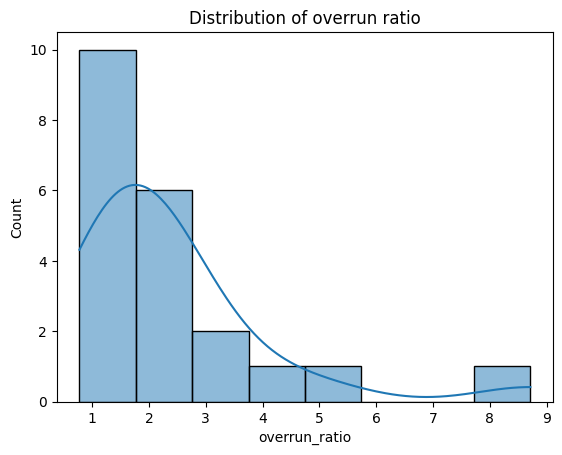

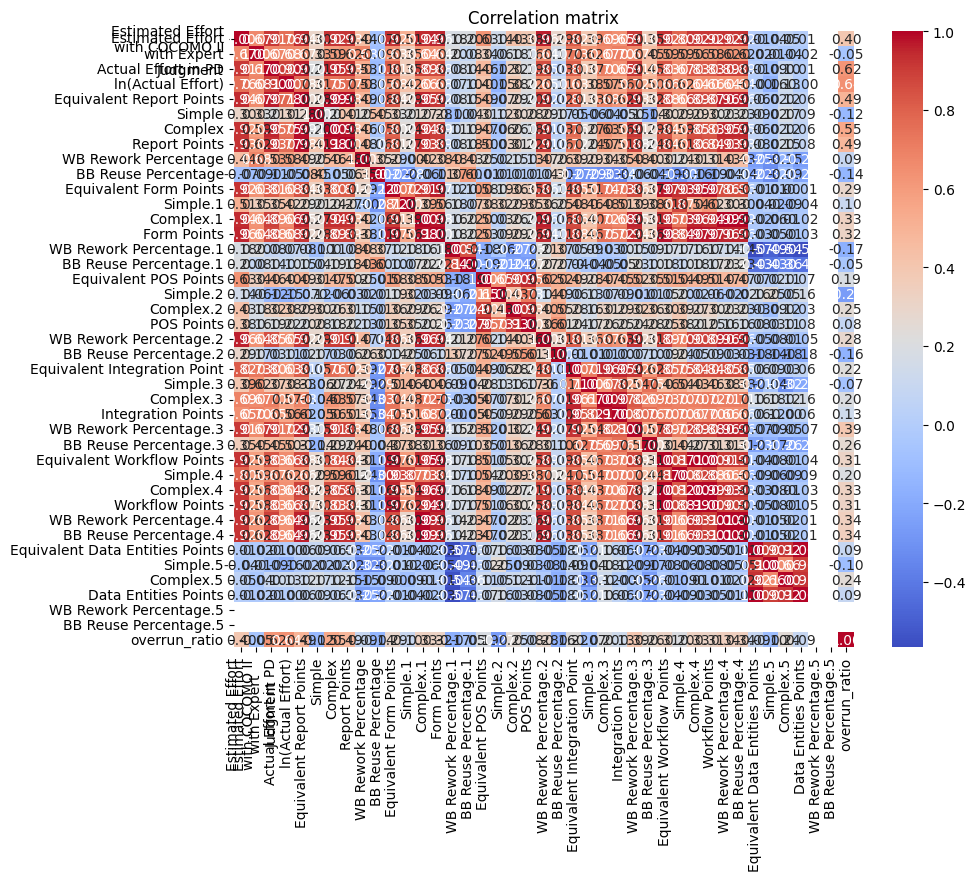

In [12]:
# Create target variable: overrun ratio = actual_effort / estimated_effort
df["overrun_ratio"] = df["Actual Effort in PD"] / df["Estimated Effort\nwith Expert\nJudgment"]

# Check distribution
sns.histplot(df["overrun_ratio"], kde=True)
plt.title("Distribution of overrun ratio")
plt.show()

# Correlation heatmap
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=np.number)
corr = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

In [13]:
df.columns  # See all columns
df.dtypes   # See data types


,0
Project Code,object
Domain/Industry,object
Modules,object
Estimated Effort\nwith COCOMO II,float64
Estimated Effort\nwith Expert\nJudgment,int64
Actual Effort in PD,int64
ln(Actual Effort),float64
Equivalent Report Points,float64
Simple,int64
Complex,int64


In [14]:
# Clean column names
df.columns = df.columns.str.replace(r'\n', ' ', regex=True).str.replace(r'\.','', regex=True).str.strip()

# Confirm cleanup
print(df.columns.tolist())


['Project Code', 'Domain/Industry', 'Modules', 'Estimated Effort with COCOMO II', 'Estimated Effort with Expert Judgment', 'Actual Effort in PD', 'ln(Actual Effort)', 'Equivalent Report Points', 'Simple', 'Complex', 'Report Points', 'WB Rework Percentage', 'BB Reuse Percentage', 'Equivalent Form Points', 'Simple1', 'Complex1', 'Form Points', 'WB Rework Percentage1', 'BB Reuse Percentage1', 'Equivalent POS Points', 'Simple2', 'Complex2', 'POS Points', 'WB Rework Percentage2', 'BB Reuse Percentage2', 'Equivalent Integration Point', 'Simple3', 'Complex3', 'Integration Points', 'WB Rework Percentage3', 'BB Reuse Percentage3', 'Equivalent Workflow Points', 'Simple4', 'Complex4', 'Workflow Points', 'WB Rework Percentage4', 'BB Reuse Percentage4', 'Equivalent Data Entities Points', 'Simple5', 'Complex5', 'Data Entities Points', 'WB Rework Percentage5', 'BB Reuse Percentage5', 'overrun_ratio']


In [15]:
# Drop these: identifiers, target breakdowns, alternate estimates
drop_cols = [
    'Project Code',
    'Domain/Industry',
    'Modules',
    'Actual Effort in PD',
    'Estimated Effort with Expert Judgment',
    'ln(Actual Effort)'
]

# Define X and y
X = df.drop(columns=drop_cols + ['overrun_ratio'])
y = df['overrun_ratio']


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [17]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("MAE :", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R²  :", r2_score(y_test, y_pred_rf))


MAE : 0.8802638807581193
RMSE: 1.0314583276337657
R²  : -2.1513553962022844


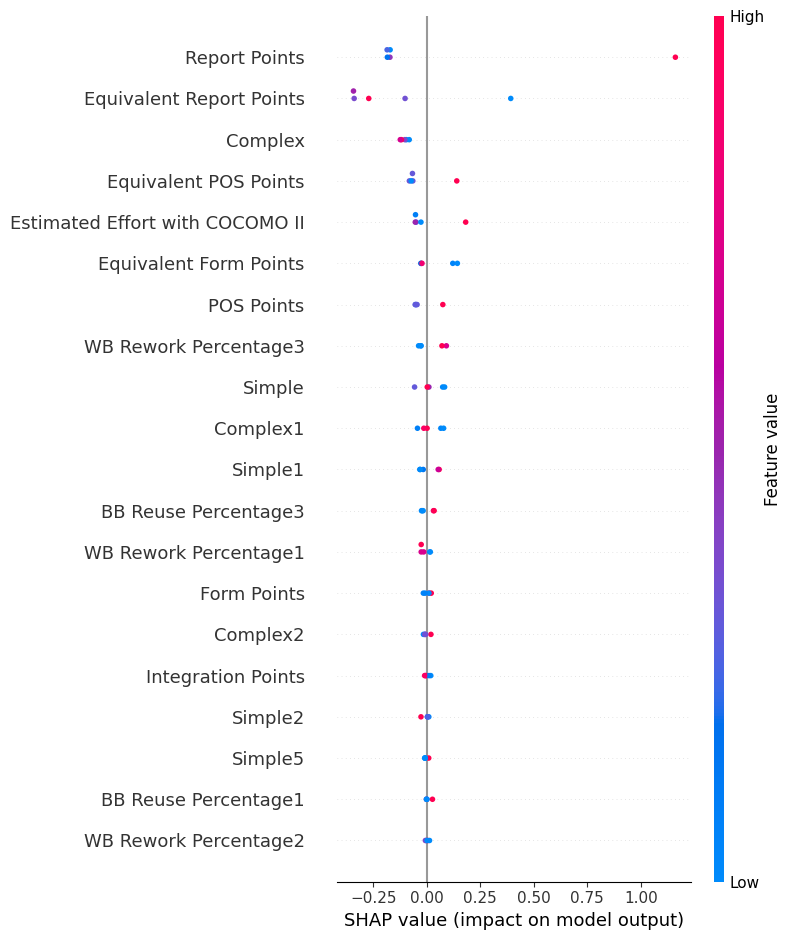

In [19]:
import shap

explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


In [20]:
# Example: use median values from training set
new_project = X_train.median().to_frame().T

# You can manually tweak values here
new_project['Equivalent Report Points'] = 100
new_project['Equivalent Integration Point'] = 80

# Predict
predicted_overrun = rf.predict(new_project)
print("Predicted overrun ratio:", predicted_overrun[0])


Predicted overrun ratio: 1.388455976620171


In [21]:
!pip install ipywidgets plotly --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.1 MB/s eta 0:00:00


In [22]:
from google.colab import output
output.enable_custom_widget_manager()


In [23]:
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, clear_output

# Define widgets for selected features
report_points = widgets.IntSlider(min=0, max=300, step=10, value=100, description='Report Pts')
integration_points = widgets.IntSlider(min=0, max=200, step=10, value=80, description='Integration')
form_points = widgets.IntSlider(min=0, max=200, step=10, value=60, description='Form Pts')
workflow_points = widgets.IntSlider(min=0, max=150, step=10, value=50, description='Workflow')

# Predict button
predict_button = widgets.Button(description="Predict Overrun")
output_area = widgets.Output()

def predict_overrun(change):
    with output_area:
        clear_output()
        # Create single-row DataFrame
        input_data = X_train.median().copy()
        input_data['Equivalent Report Points'] = report_points.value
        input_data['Equivalent Integration Point'] = integration_points.value
        input_data['Equivalent Form Points'] = form_points.value
        input_data['Equivalent Workflow Points'] = workflow_points.value

        # Reshape for prediction
        prediction = rf.predict([input_data])
        pred_value = round(prediction[0], 2)

        # Display prediction in plot
        fig = go.Figure(go.Indicator(
            mode = "gauge+number+delta",
            value = pred_value,
            delta = {'reference': 1.0, 'increasing': {'color': "red"}, 'decreasing': {'color': "green"}},
            title = {'text': "Predicted Overrun Ratio"},
            gauge = {
                'axis': {'range': [0, 3]},
                'bar': {'color': "darkblue"},
                'steps' : [
                    {'range': [0, 1], 'color': "lightgreen"},
                    {'range': [1, 1.5], 'color': "yellow"},
                    {'range': [1.5, 3], 'color': "red"}
                ],
                'threshold' : {'line': {'color': "black", 'width': 4}, 'thickness': 0.75, 'value': 1}
            }
        ))

        fig.show()
        print(f"Overrun Ratio: {pred_value} → {(pred_value - 1)*100:.1f}% over estimate" if pred_value > 1 else f"{(1 - pred_value)*100:.1f}% under estimate")

# Connect button to function
predict_button.on_click(predict_overrun)

# Display widgets
display(report_points, integration_points, form_points, workflow_points, predict_button, output_area)


IntSlider(value=100, description='Report Pts', max=300, step=10)

IntSlider(value=80, description='Integration', max=200, step=10)

IntSlider(value=60, description='Form Pts', max=200, step=10)

IntSlider(value=50, description='Workflow', max=150, step=10)

Button(description='Predict Overrun', style=ButtonStyle())

Output()

In [24]:
from sklearn.linear_model import LinearRegression

# Train the model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict on test set
y_pred_lr = linreg.predict(X_test)

# Evaluate
print("📉 Linear Regression Performance:")
print("MAE :", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R²  :", r2_score(y_test, y_pred_lr))


📉 Linear Regression Performance:
MAE : 11.297169335733937
RMSE: 17.448750162639186
R²  : -900.8258074193594


In [25]:
# Dropdown to select model
model_selector = widgets.Dropdown(
    options=['Random Forest', 'Linear Regression'],
    value='Random Forest',
    description='Model:',
    style={'description_width': 'initial'}
)

def predict_overrun_updated(change):
    with output_area:
        clear_output()

        # Get input features
        input_data = X_train.median().copy()
        input_data['Equivalent Report Points'] = report_points.value
        input_data['Equivalent Integration Point'] = integration_points.value
        input_data['Equivalent Form Points'] = form_points.value
        input_data['Equivalent Workflow Points'] = workflow_points.value

        # Pick model
        if model_selector.value == 'Random Forest':
            pred_model = rf
        else:
            pred_model = linreg

        # Make prediction
        prediction = pred_model.predict([input_data])[0]
        pred_value = round(prediction, 2)

        # Plot gauge
        fig = go.Figure(go.Indicator(
            mode="gauge+number+delta",
            value=pred_value,
            delta={'reference': 1.0, 'increasing': {'color': "red"}, 'decreasing': {'color': "green"}},
            title={'text': f"Predicted Overrun Ratio ({model_selector.value})"},
            gauge={
                'axis': {'range': [0, 3]},
                'bar': {'color': "darkblue"},
                'steps': [
                    {'range': [0, 1], 'color': "lightgreen"},
                    {'range': [1, 1.5], 'color': "yellow"},
                    {'range': [1.5, 3], 'color': "red"}
                ],
                'threshold': {'line': {'color': "black", 'width': 4}, 'thickness': 0.75, 'value': 1}
            }
        ))
        fig.show()

        # Print numeric result
        if pred_value > 1:
            print(f"⚠️ Overrun Ratio: {pred_value} → ~{(pred_value - 1)*100:.1f}% over estimate")
        else:
            print(f"✅ Under estimate: ~{(1 - pred_value)*100:.1f}% below estimate")

# Connect button to function
predict_button.on_click(predict_overrun_updated)

# Display updated UI
display(model_selector, report_points, integration_points, form_points, workflow_points, predict_button, output_area)


Dropdown(description='Model:', options=('Random Forest', 'Linear Regression'), style=DescriptionStyle(descript…

IntSlider(value=70, description='Report Pts', max=300, step=10)

IntSlider(value=100, description='Integration', max=200, step=10)

IntSlider(value=50, description='Form Pts', max=200, step=10)

IntSlider(value=80, description='Workflow', max=150, step=10)

Button(description='Predict Overrun', style=ButtonStyle())

Output()

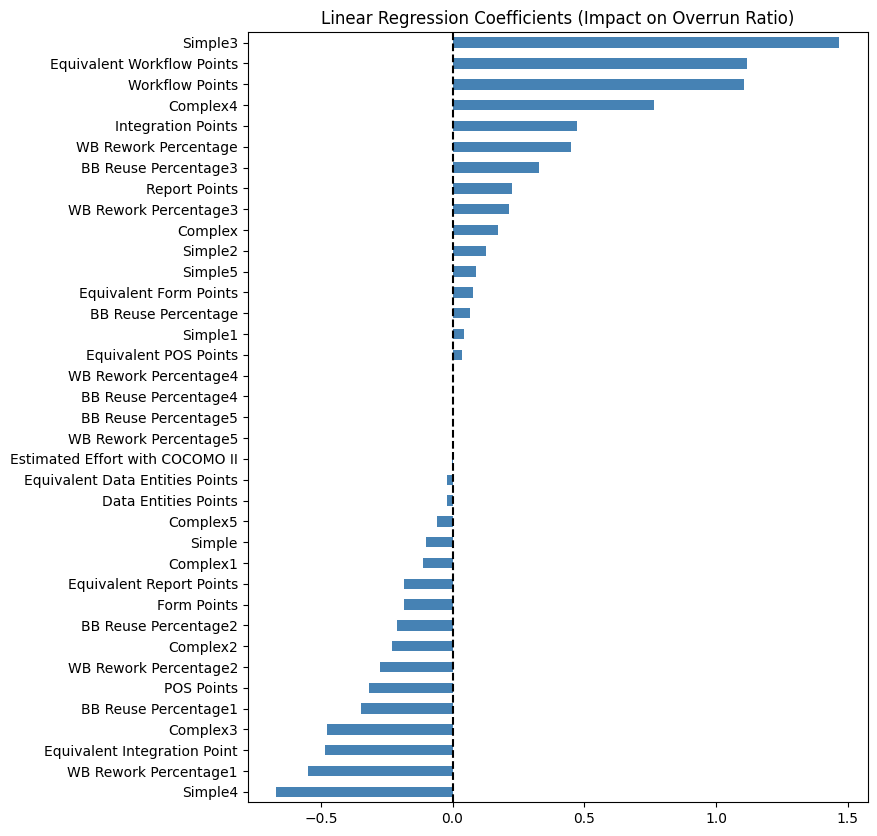

In [26]:
coeffs = pd.Series(linreg.coef_, index=X_train.columns)
coeffs.sort_values().plot(kind='barh', figsize=(8, 10), color='steelblue')
plt.title("Linear Regression Coefficients (Impact on Overrun Ratio)")
plt.axvline(0, color='black', linestyle='--')
plt.show()
